In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.models import HoverTool
from pathlib import Path
from scipy.interpolate import interp1d
from tqdm import tqdm

In [2]:
MODEL_DIRECTORY = Path('../model/')
ISOCHRONES_DIRECTORY = Path ('../isochrones/')
MAIN_DIRECTORY = Path('../')

In [3]:
def read_file(filename):
    df = pd.read_csv(filename, delimiter='\\s+')
    df = df.apply(pd.to_numeric, errors='coerce')
    try:
        df.dropna(subset = ['phot_g_mean_mag','bp_rp'], inplace = True)
    except:
        pass
    return df

def plot_CMD (data):
    source = ColumnDataSource(
            data=dict(
                x=data['bp-rp, mag'],
                y=data['g, mag'],
            )
        )
    hover = HoverTool(
            tooltips=[
                ("index", "$index"),
                ("(x,y)", "($x, $y)"),
            ]
        )
    output_file(f'CMD.html')
    
    p = figure(plot_width=1300, plot_height=900, tools=[hover],x_range = (-0.5, 3), y_range = (23, 6))
    p.circle('x', 'y', size=5, source=source, color = "black", alpha = 0.65)
    return show(p)

def plot_CMD_binaries (data_s, data_b):
    source_s = ColumnDataSource(
            data=dict(
                x=data_s['bp-rp, mag'],
                y=data_s['g, mag'],
            )
        )
    source_b = ColumnDataSource(
            data=dict(
                x=data_b['bp-rp, mag'],
                y=data_b['g, mag'],
            )
    )
    hover = HoverTool(
            tooltips=[
                ("index", "$index"),
                ("(x,y)", "($x, $y)"),
            ]
        )
    output_file(f'CMD.html')
    
    p = figure(plot_width=1300, plot_height=900, tools=[hover],x_range = (-0.5, 3), y_range = (23, 6))
    p.circle('x', 'y', size=5, source=source_s, color = "black", alpha = 0.65)
    p.circle('x', 'y', size=5, source=source_b, color = "red", alpha = 0.75)
    return show(p)

def interp (a, b, c): 
    """get mass of starS with definite magnitude"""
    func = interp1d(a, b)
    return func(c)

In [4]:
cluster_data = read_file(MODEL_DIRECTORY / 'model_stars_250pc_manystars_flat.txt')
#plot_CMD(cluster_data)

In [5]:
isochrone = read_file(MODEL_DIRECTORY / 'isochrone_model_8.38.txt')

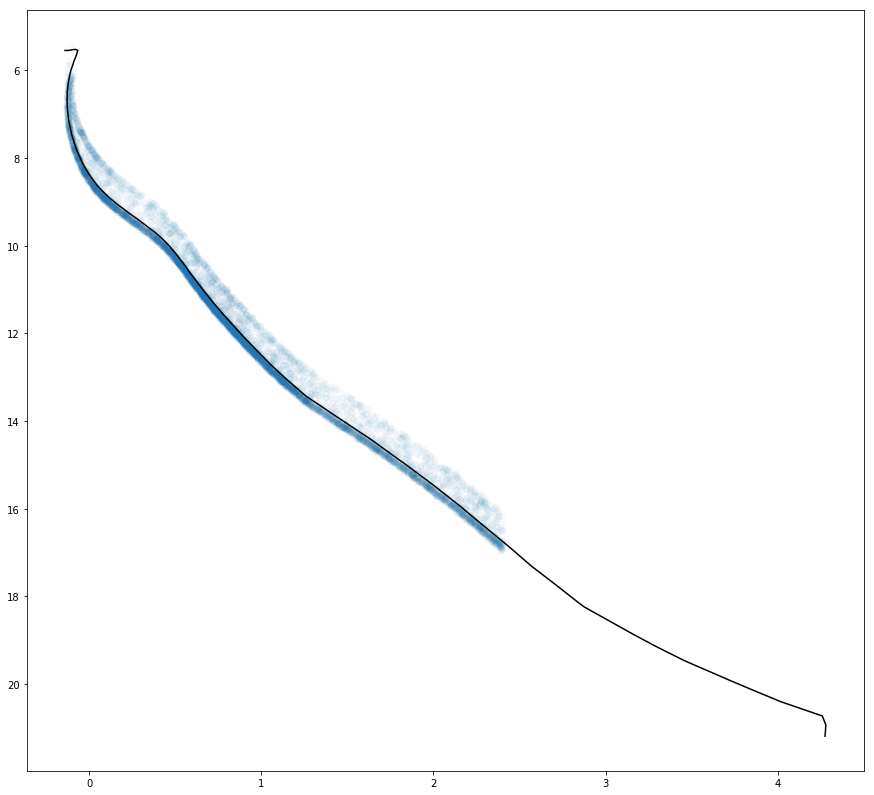

In [7]:
isochrone['g, mag'] = isochrone['Gmag'] + 5 * np.log10(250) - 5 - 0.13
fig, ax = plt.subplots(figsize=(15,14))
plt.scatter(cluster_data['bp-rp, mag'], cluster_data['g, mag'], alpha=0.025)
plt.plot(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['g, mag'], c='black')

ax.invert_yaxis()
#plt.savefig('CMD_model_500pc_flat.pdf')

In [8]:
for index in tqdm(range(len(cluster_data))):
    
    g_isochrone = interp(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['g, mag'], 
                         cluster_data.loc[index, 'bp-rp, mag'])
    
    if g_isochrone + 0.4 < cluster_data.loc[index, 'g, mag']:
        cluster_data = cluster_data.drop(index=index,axis=0)
cluster_data.index = pd.RangeIndex(len(cluster_data.index))
        #binaries_data.index = pd.RangeIndex(len(binaries_data.index))

100%|██████████| 7828/7828 [00:03<00:00, 2299.65it/s]


In [9]:
singles_data = cluster_data.copy()
binaries_data = pd.DataFrame()

In [10]:
for index in tqdm(range(len(cluster_data))):
    
    g_isochrone = interp(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['g, mag'], 
                         singles_data.loc[index, 'bp-rp, mag'])
    #except:
    #    g_isochrone = interp(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['g, mag'], -0.128)
    if g_isochrone > singles_data.loc[index, 'g, mag']:
        binaries_data = binaries_data.append(singles_data.loc[index])
        binaries_data = binaries_data[singles_data.columns]
        singles_data = singles_data.drop(index=index,axis=0)
        #singles_data.index = pd.RangeIndex(len(singles_data.index))
        #binaries_data.index = pd.RangeIndex(len(binaries_data.index))

100%|██████████| 7499/7499 [00:08<00:00, 865.42it/s] 


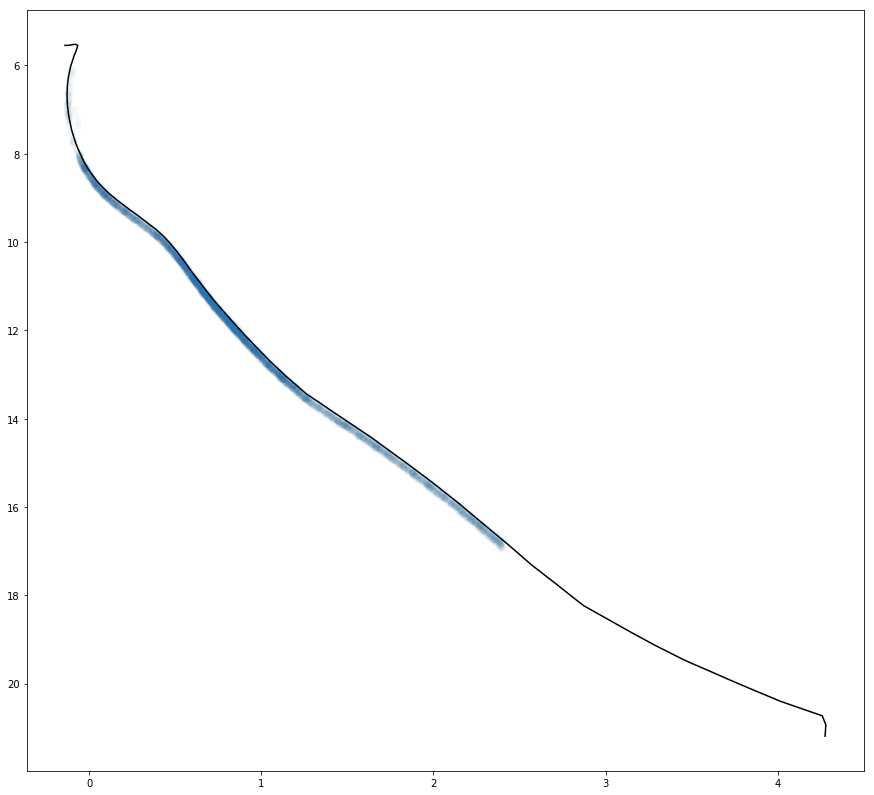

In [11]:
fig, ax = plt.subplots(figsize=(15,14))
plt.scatter(singles_data['bp-rp, mag'], singles_data['g, mag'], alpha=0.015)
plt.plot(isochrone['G_BPmag'] - isochrone['G_RPmag'], isochrone['g, mag'], c='black')

ax.invert_yaxis()

In [12]:
singles_data.to_csv(MODEL_DIRECTORY / 'model_separated_singles_250pc_manystars_flat.txt', sep=' ', index=False, na_rep='Nan')
binaries_data.to_csv(MODEL_DIRECTORY / 'model_separated_binaries_250pc_manystars_flat.txt', sep=' ', index=False, na_rep='Nan')
